<a href="https://colab.research.google.com/github/Rakesh9901491946/AlgoCasts/blob/master/06_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: CIFAR-10 classification

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

> "consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

>The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

<img src="http://drive.google.com/uc?export=view&id=1wlfkvZgS0oBDwxKicWmYgtsJmP3IcMdj">

# Preliminaries

In [3]:
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.initializers import glorot_normal

# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(14)
tf.random.set_seed(19)


Download the data if necessary and load it:

In [4]:
# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Step 1: Split the training data into training and validation sets (80% training, 20% validation)
valid_size = 10000  # Let's use 10,000 samples for validation
train_images, valid_images = train_images[:-valid_size], train_images[-valid_size:]
train_labels, valid_labels = train_labels[:-valid_size], train_labels[-valid_size:]

# Step 2: Normalize the pixel values to be between 0 and 1
train_images = train_images.astype("float32") / 255.0
valid_images = valid_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Step 3: Print the shapes of the datasets
print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 1) (10000, 1) (10000, 1)


### Categories:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [5]:
# TODO: Fill in the classes
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


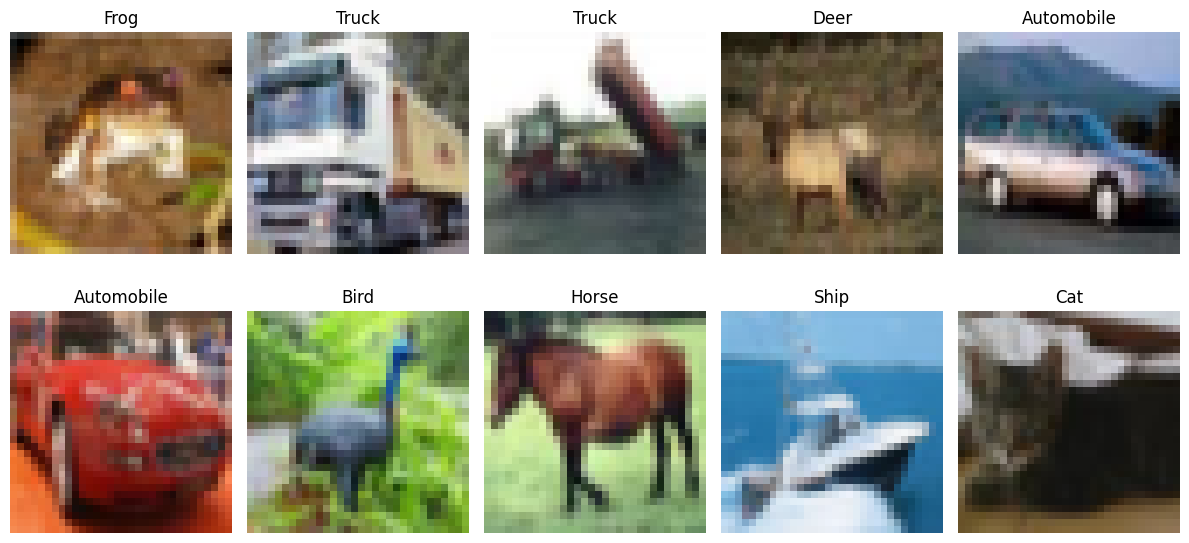

In [6]:
# TODO: Plot some of the images along with their labels
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 10

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot the first 10 images from the training set
for i in range(num_images):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(train_images[i])  # Display the image
    plt.axis('off')  # Hide axis labels
    plt.title(classes[train_labels[i][0]])  # Show the class label (train_labels[i][0] because it's a 2D array)

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()


# Model

## Parameters

In [20]:
# Dropout rates
# Dropout rate for convolutional layers: Typically between 0.2 and 0.5
dropout_rate_1 = 0.3  # A common choice for convolutional layers

# Dropout rate for fully connected layers: Typically between 0.3 and 0.5
dropout_rate_2 = 0.4  # A slightly higher dropout rate for fully connected layers

# Batch size: Common values are 32, 64, 128
batch_size = 64  # This is a reasonable default for moderate size datasets

# Epoch count: This can vary, but a common range is between 10 and 50 epochs
epoch_count = 50  # A typical starting point for many tasks; you can adjust based on validation performance


## Network

In [21]:
# adapted from https://github.com/jtopor/CUNY-MSDA-661/blob/master/CIFAR-CNN/TF-Layers-CIFAR-GITHUB-v3.py

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
tf.compat.v1.reset_default_graph() # It's good practice to clean and reset everything
clear_session()          # even using Keras




# Model
#######

# Define the input!
# Remember, we have pictures with 32x32 pixels and 3 color channels (RGB)
# The shape would be (32, 32, 3), but batch size is handled automatically by Keras
x = Input(shape=(32, 32, 3))  # Define the input layer (no batch size)

# Convolutional Layer #1: (batch_size, 32, 32, 3) -> (batch_size, 32, 32, 64)
# 64 filters, 5x5 kernel, padding='same', activation='relu'
conv1 = Conv2D(64, (5, 5), padding='same', activation='relu')(x)

# Pooling Layer #1: (batch_size, 32, 32, 64) -> (batch_size, 16, 16, 64)
# Max pooling with pool size 2x2 and stride 2
pool1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)

# Define a dropout layer with the first dropout rate parameter (e.g., dropout_rate_1 = 0.3)
dropout1 = Dropout(dropout_rate_1)(pool1)

# Convolutional Layer #2: (batch_size, 16, 16, 64) -> (batch_size, 16, 16, 64)
# Another convolutional layer with the same parameters
conv2 = Conv2D(64, (5, 5), padding='same', activation='relu')(dropout1)

# Pooling Layer #2: (batch_size, 16, 16, 64) -> (batch_size, 8, 8, 64)
# Another max pooling layer with the same parameters
pool2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)

# Define a dropout layer with the first dropout rate parameter (e.g., dropout_rate_1 = 0.3)
dropout2 = Dropout(dropout_rate_1)(pool2)

# Convert tensors into vectors: (batch_size, 8, 8, 64) -> (batch_size, 4096)
# Use Flatten to convert the output of the convolutional layers into a 1D vector
pool2_flat = Flatten()(dropout2)

# Fully connected Layer #1: (batch_size, 4096) -> (batch_size, 512)
# Dense layer with 512 units and ReLU activation
dense1 = Dense(512, activation='relu')(pool2_flat)

# Define a dropout layer with the second dropout rate parameter (e.g., dropout_rate_2 = 0.4)
dropout3 = Dropout(dropout_rate_2)(dense1)

# Fully connected Layer #2: (batch_size, 512) -> (batch_size, 256)
# Dense layer with 256 units and ReLU activation
dense2 = Dense(256, activation='relu')(dropout3)

# Define a dropout layer with the second dropout rate parameter (e.g., dropout_rate_2 = 0.4)
dropout4 = Dropout(dropout_rate_2)(dense2)

# Logits layer: (batch_size, 256) -> (batch_size, 10)
# Output layer with 10 units (for 10 classes) and softmax activation (since it's a classification problem)
predictions = Dense(10, activation='softmax')(dropout4)

# Full model
# Instantiate (initialize) the model with inputs and outputs
model = Model(inputs=x, outputs=predictions)

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,338,890 (8.92 MB)

 Trainable params: 2,338,890 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

## Loss, optimization and compilation

In [22]:
# Loss function: Sparse categorical crossentropy (for integer labels, not one-hot encoded)
loss = 'sparse_categorical_crossentropy'

# Optimizer: Adam optimizer is a good choice for adaptive optimization
optimizer = Adam(learning_rate=0.001)  # Learning rate is typically set to 0.001 for Adam

# Compilation
#############
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


## Training

In [23]:
history = model.fit(x=train_images, y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=epoch_count,
                    batch_size=batch_size)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2947 - loss: 1.8915 - val_accuracy: 0.5010 - val_loss: 1.3833
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4952 - loss: 1.3949 - val_accuracy: 0.5881 - val_loss: 1.1690
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5529 - loss: 1.2527 - val_accuracy: 0.6133 - val_loss: 1.0883
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6006 - loss: 1.1427 - val_accuracy: 0.6480 - val_loss: 1.0172
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6232 - loss: 1.0596 - val_accuracy: 0.6693 - val_loss: 0.9600
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6495 - loss: 1.0039 - val_accuracy: 0.6675 - val_loss: 0.9536
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6690 - loss: 0.9431 - val_accuracy: 0.6951 - val_loss: 0.8870
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6867 - loss: 0.8905 - val_accuracy: 0.

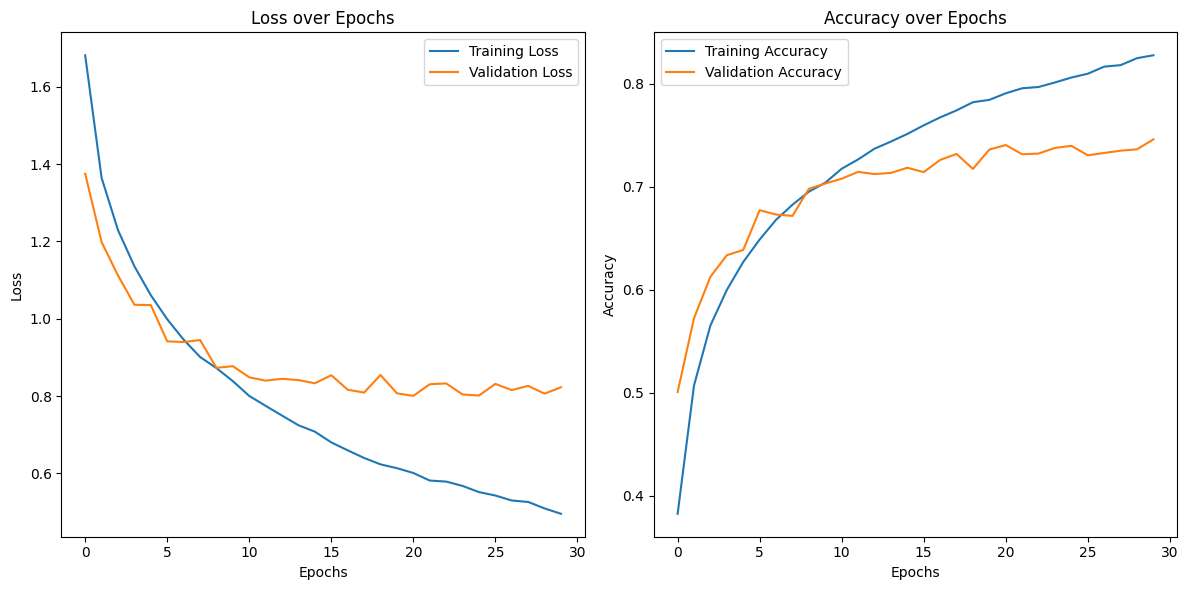

In [17]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the history object
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
history_acc = history.history['accuracy']
history_val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Training Loss')
plt.plot(history_val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_acc, label='Training Accuracy')
plt.plot(history_val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [25]:
assert max(history.history['val_accuracy']) > 0.73

## Visualization

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


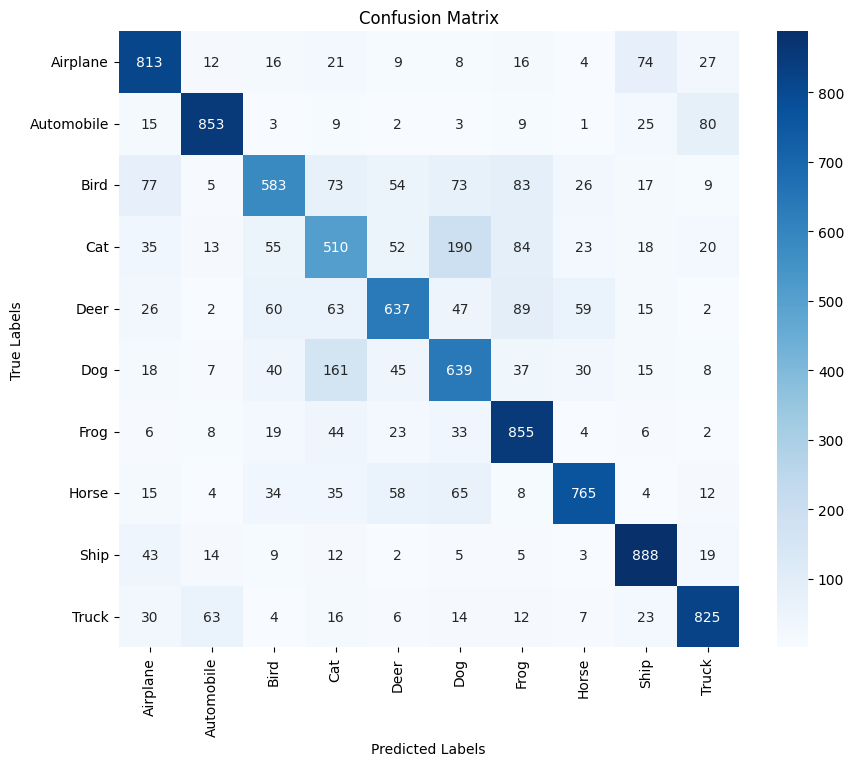

In [26]:
# TODO: Plot Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test data
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


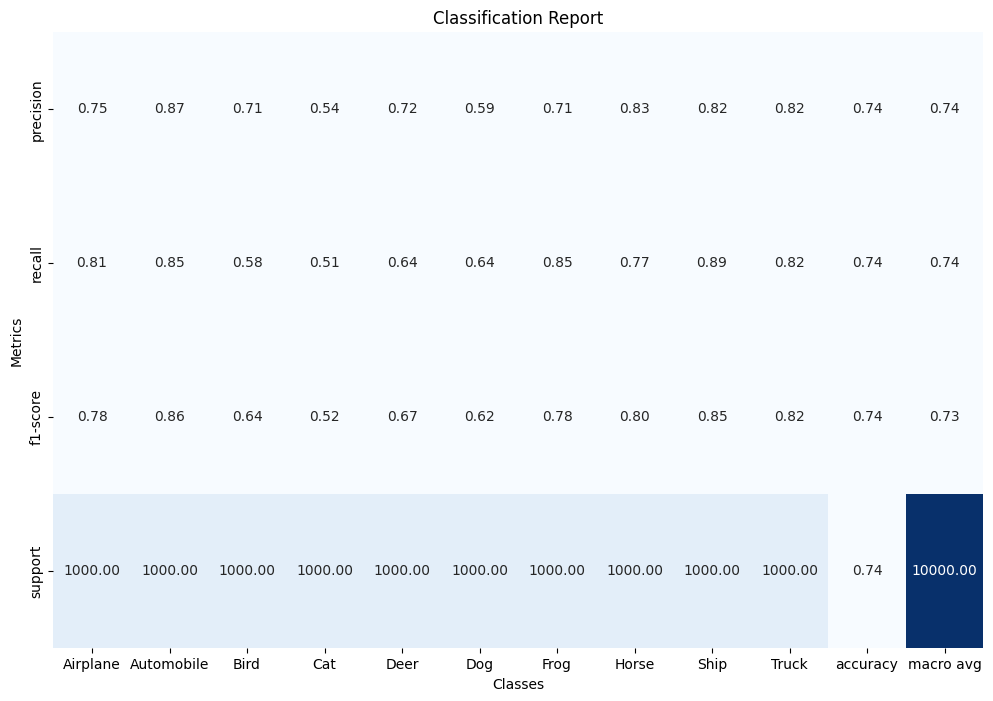

In [27]:
# TODO: Plot Classification Report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

# Make predictions on the test data
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability

# Compute the classification report
report = classification_report(test_labels, y_pred_classes, target_names=classes, output_dict=True)

# Convert the classification report into a pandas DataFrame for better visualization
import pandas as pd
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.show()
